# 偉裕生技 銀耳專案

In [1]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

rootpath = '/media/share/data/Tremella_fuciformis/'

In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "session_name = " + "'"+thename+"'";
kernel.execute(command);

In [13]:
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le = LabelEncoder().fit(['C', 'F'])

def img_gen(indexlist):
    img_file = []
    label = []
    for idx in indexlist:
        subpath = os.path.join(rootpath, df_train['SN'][idx])
        target = str(df_train['CanSN'][idx]).split('.')[0]
        img = plt.imread(subpath + '/image_' + target +'.jpg')
        if img.shape[0] > img.shape[1]:
            img = np.transpose(img, (1, 0, 2))

        img_file.append(resize(img, (256, 256, 3), mode='reflect'))
        label.append(int(df_train['Weight_mean'][idx]))
    
    img_demean = np.array(img_file) - np.mean(img_file)
#     labels = to_categorical(le.transform(label), num_classes=2)
    return np.array(img_file), label

# Densenet

In [34]:
import keras.backend as K
from keras.applications import densenet
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

K.clear_session()
base_model = densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1, activation='relu')(x)

model = Model(inputs=base_model.input, outputs=x)
model.summary()

def acc1(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*5), axis=-1)
def acc2(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*10), axis=-1)
# def acc3(y_true, y_pred):
#     return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*3), axis=-1)

model.compile(optimizer=Adam(lr=0.02), loss='mse', metrics=[acc1, acc2])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

# Trainning

In [35]:
from sklearn.model_selection import StratifiedKFold
n_flod = 5
df_train = pd.read_csv(rootpath + 'T8_train.csv')
skf = StratifiedKFold(n_flod, shuffle=True, random_state=np.random)
for train_idx, val_idx in skf.split(df_train, df_train['c50p']):
    break
    
print(len(train_idx))

92


In [36]:
train_gen = ImageDataGenerator(rotation_range=[-45, 45],
                               zoom_range=[0.85, 1.15], 
                               horizontal_flip=True, 
                               vertical_flip=True)

In [37]:
X_train, y_train = s(train_idx)
X_val, y_val = img_gen(val_idx)

In [42]:
model.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=[acc1, acc2])

In [54]:
model.load_weights('fungus-mse-02-acc20.6916.hdf5')

model_checkpoint = ModelCheckpoint('ieee-camera-'+session_name+'_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint('ieee-camera-'+session_name+'_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)

adlr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=1e-6)
# model_earlystop = EarlyStopping(patience=32, monitor='val_acc')

batch_size = 32

train_history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size), 
                                    epochs=2**6, steps_per_epoch=len(X_train), 
                                    validation_data=train_gen.flow(X_val, y_val, batch_size), 
                                    validation_steps=len(X_val),
                                    verbose=2, 
                                    callbacks=[model_checkpoint, adlr])

Epoch 1/64
 - 39s - loss: 54.4464 - acc1: 0.6171 - acc2: 0.8373 - val_loss: 451.9419 - val_acc1: 0.1234 - val_acc2: 0.3219
Epoch 2/64
 - 40s - loss: 50.6304 - acc1: 0.6524 - acc2: 0.8713 - val_loss: 182.0947 - val_acc1: 0.3723 - val_acc2: 0.5990
Epoch 3/64
 - 38s - loss: 47.9227 - acc1: 0.7001 - acc2: 0.8820 - val_loss: 213.8775 - val_acc1: 0.3092 - val_acc2: 0.5364
Epoch 4/64
 - 39s - loss: 50.2518 - acc1: 0.6483 - acc2: 0.8611 - val_loss: 144.3471 - val_acc1: 0.4258 - val_acc2: 0.6738
Epoch 5/64
 - 38s - loss: 41.3267 - acc1: 0.7227 - acc2: 0.8798 - val_loss: 185.2004 - val_acc1: 0.3230 - val_acc2: 0.5749
Epoch 6/64
 - 39s - loss: 44.5108 - acc1: 0.7200 - acc2: 0.8730 - val_loss: 156.2873 - val_acc1: 0.4315 - val_acc2: 0.7146
Epoch 7/64
 - 38s - loss: 44.7410 - acc1: 0.7008 - acc2: 0.8789 - val_loss: 201.0014 - val_acc1: 0.3546 - val_acc2: 0.6047
Epoch 8/64
 - 38s - loss: 39.6066 - acc1: 0.7477 - acc2: 0.8882 - val_loss: 172.9650 - val_acc1: 0.4171 - val_acc2: 0.7175
Epoch 9/64
 - 36

# Evaluation

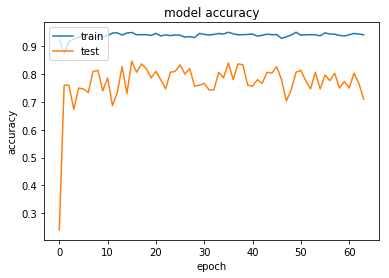

In [54]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

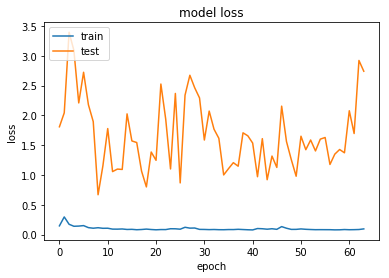

In [55]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
model.load_weights('fungus-test20180201-smcw-16-0.8467.hdf5')
model.evaluate(X_val, y_val)

25/25 [==============================] - 0s 7ms/step


[3.8683428764343262, 0.75999999046325684]

In [57]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_val).argmax(axis=-1)
print(classification_report(y_val.argmax(axis=-1), y_pred, target_names=['A-60', 'B-60']))

             precision    recall  f1-score   support

       A-60       0.76      1.00      0.86        19
       B-60       0.00      0.00      0.00         6

avg / total       0.58      0.76      0.66        25



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
model.save('Tremella_fuciformis.hdf5')

# Prediction

In [ ]:
img = plt.imread('/media/share/data/Tremella_fuciformis/T8-170705/image_5.jpg')
img = resize(img, (256, 256, 3), mode='reflect')
# img = img[np.newaxis, :, :, :]

In [ ]:
y_pred = model.predict(img)

In [ ]:
%%javascript
Jupyter.notebook.session.delete();